# Appendix A: Spectral Manifold Analysis (PCA)
This notebook visualizes the learned PCA basis functions and the variance coverage.
We demonstrate that 12 components are sufficient to capture complex driving maneuvers
while acting as a kinematic low-pass filter.

In [2]:
import matplotlib
if not hasattr(matplotlib.RcParams, '_get'):
    matplotlib.RcParams._get = lambda self, key: self.get(key)

import matplotlib.pyplot as plt
import numpy as np
import json
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## 1. Load PCA Data
Loading the basis generated during the training phase.

In [3]:
pca_path = "/mnt/d/waymo_datasets/Deep-Flow_Dataset/pca_basis.json"

with open(pca_path, "r") as f:
    pca_data = json.load(f)

components = np.array(pca_data['components']) # [12, 160]
mean_traj = np.array(pca_data['mean'])        # [160]
variance_ratio = np.array(pca_data['explained_variance'])
cumulative_variance = np.cumsum(variance_ratio)

print(f"✅ Loaded {len(variance_ratio)} components.")
print(f"Total Explained Variance: {cumulative_variance[-1]*100:.2f}%")

✅ Loaded 12 components.
Total Explained Variance: 100.00%


## 2. Cumulative Explained Variance (Scree Plot)
This figure justifies the choice of k=12. We look for the "elbow" where 
additional components provide diminishing returns.

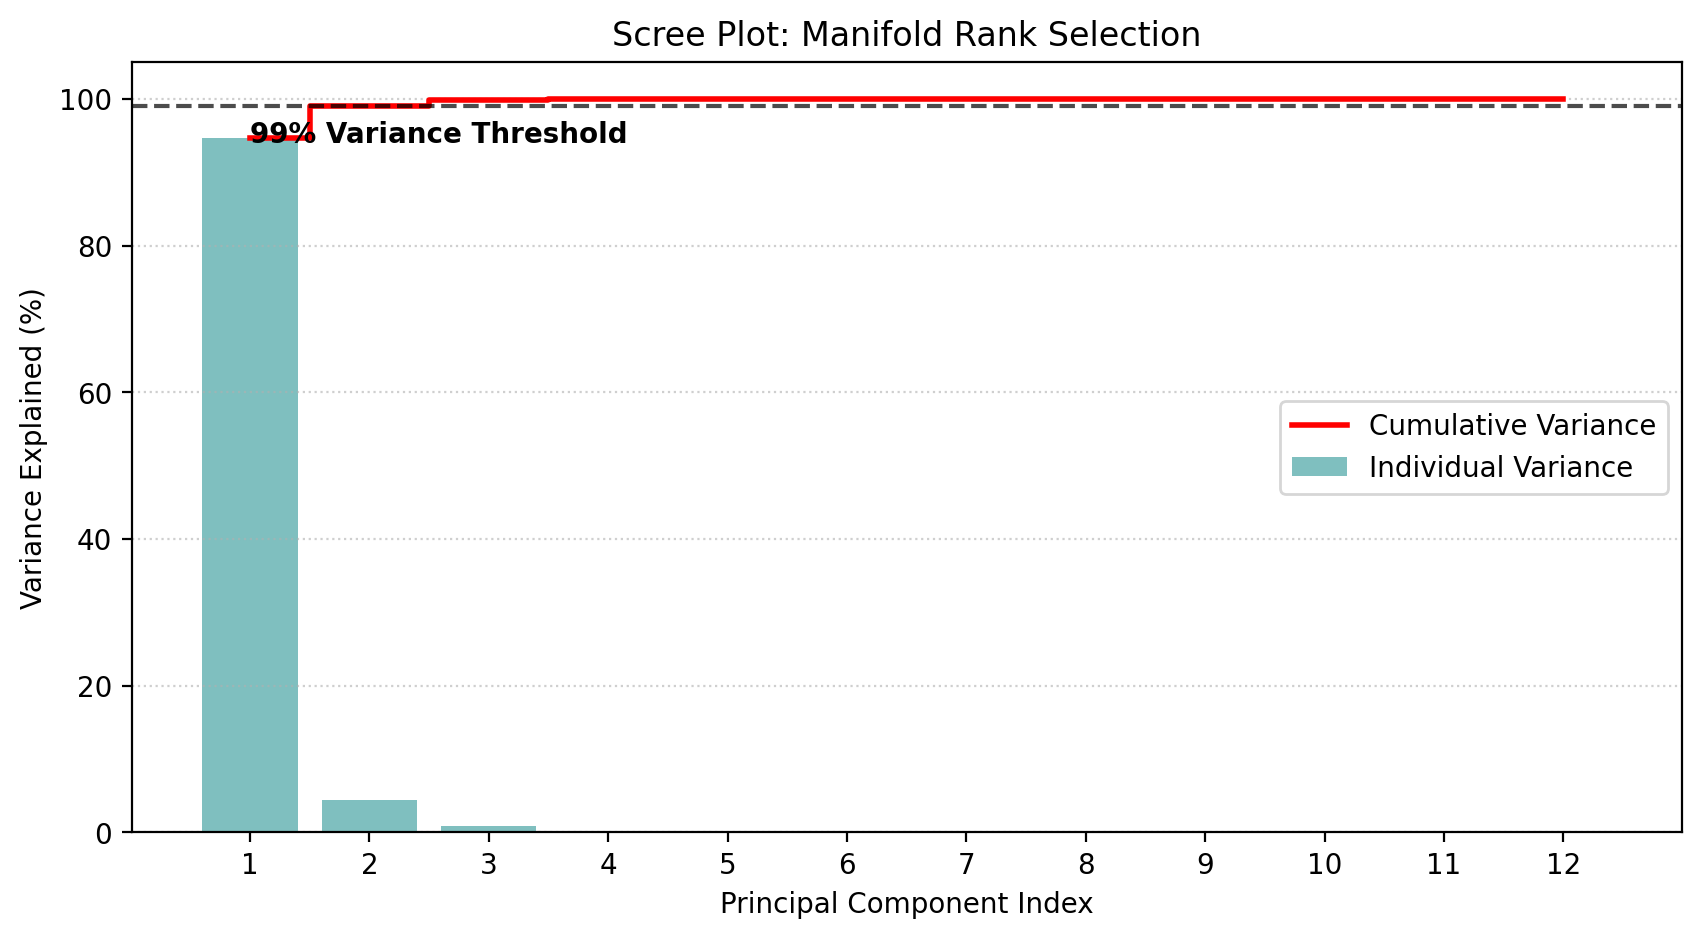

In [4]:
plt.figure(figsize=(10, 5))
x_axis = np.arange(1, len(variance_ratio) + 1)

# Plot bars for individual variance
plt.bar(x_axis, variance_ratio * 100, alpha=0.5, color='teal', label='Individual Variance')

# Plot step for cumulative variance
plt.step(x_axis, cumulative_variance * 100, where='mid', color='red', lw=2, label='Cumulative Variance')

# Threshold line at 99%
plt.axhline(y=99, color='black', linestyle='--', alpha=0.7)
plt.text(1, 94, "99% Variance Threshold", fontsize=10, fontweight='bold')

plt.xlabel('Principal Component Index')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot: Manifold Rank Selection')
plt.xticks(x_axis)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.legend(loc='center right')
plt.show()

## 3. Visualizing the Eigen-Trajectories
We plot how each component modifies the mean trajectory. 
We show: Mean (Dashed) vs Mean + 3*PC (Solid).

This reveals the "Vocabulary" of your model:
* **PC1:** Usually Longitudinal Progress (Speed).
* **PC2:** Usually Curvature (Steering).
* **PC3:** Usually Lateral Offset (Lane Change).

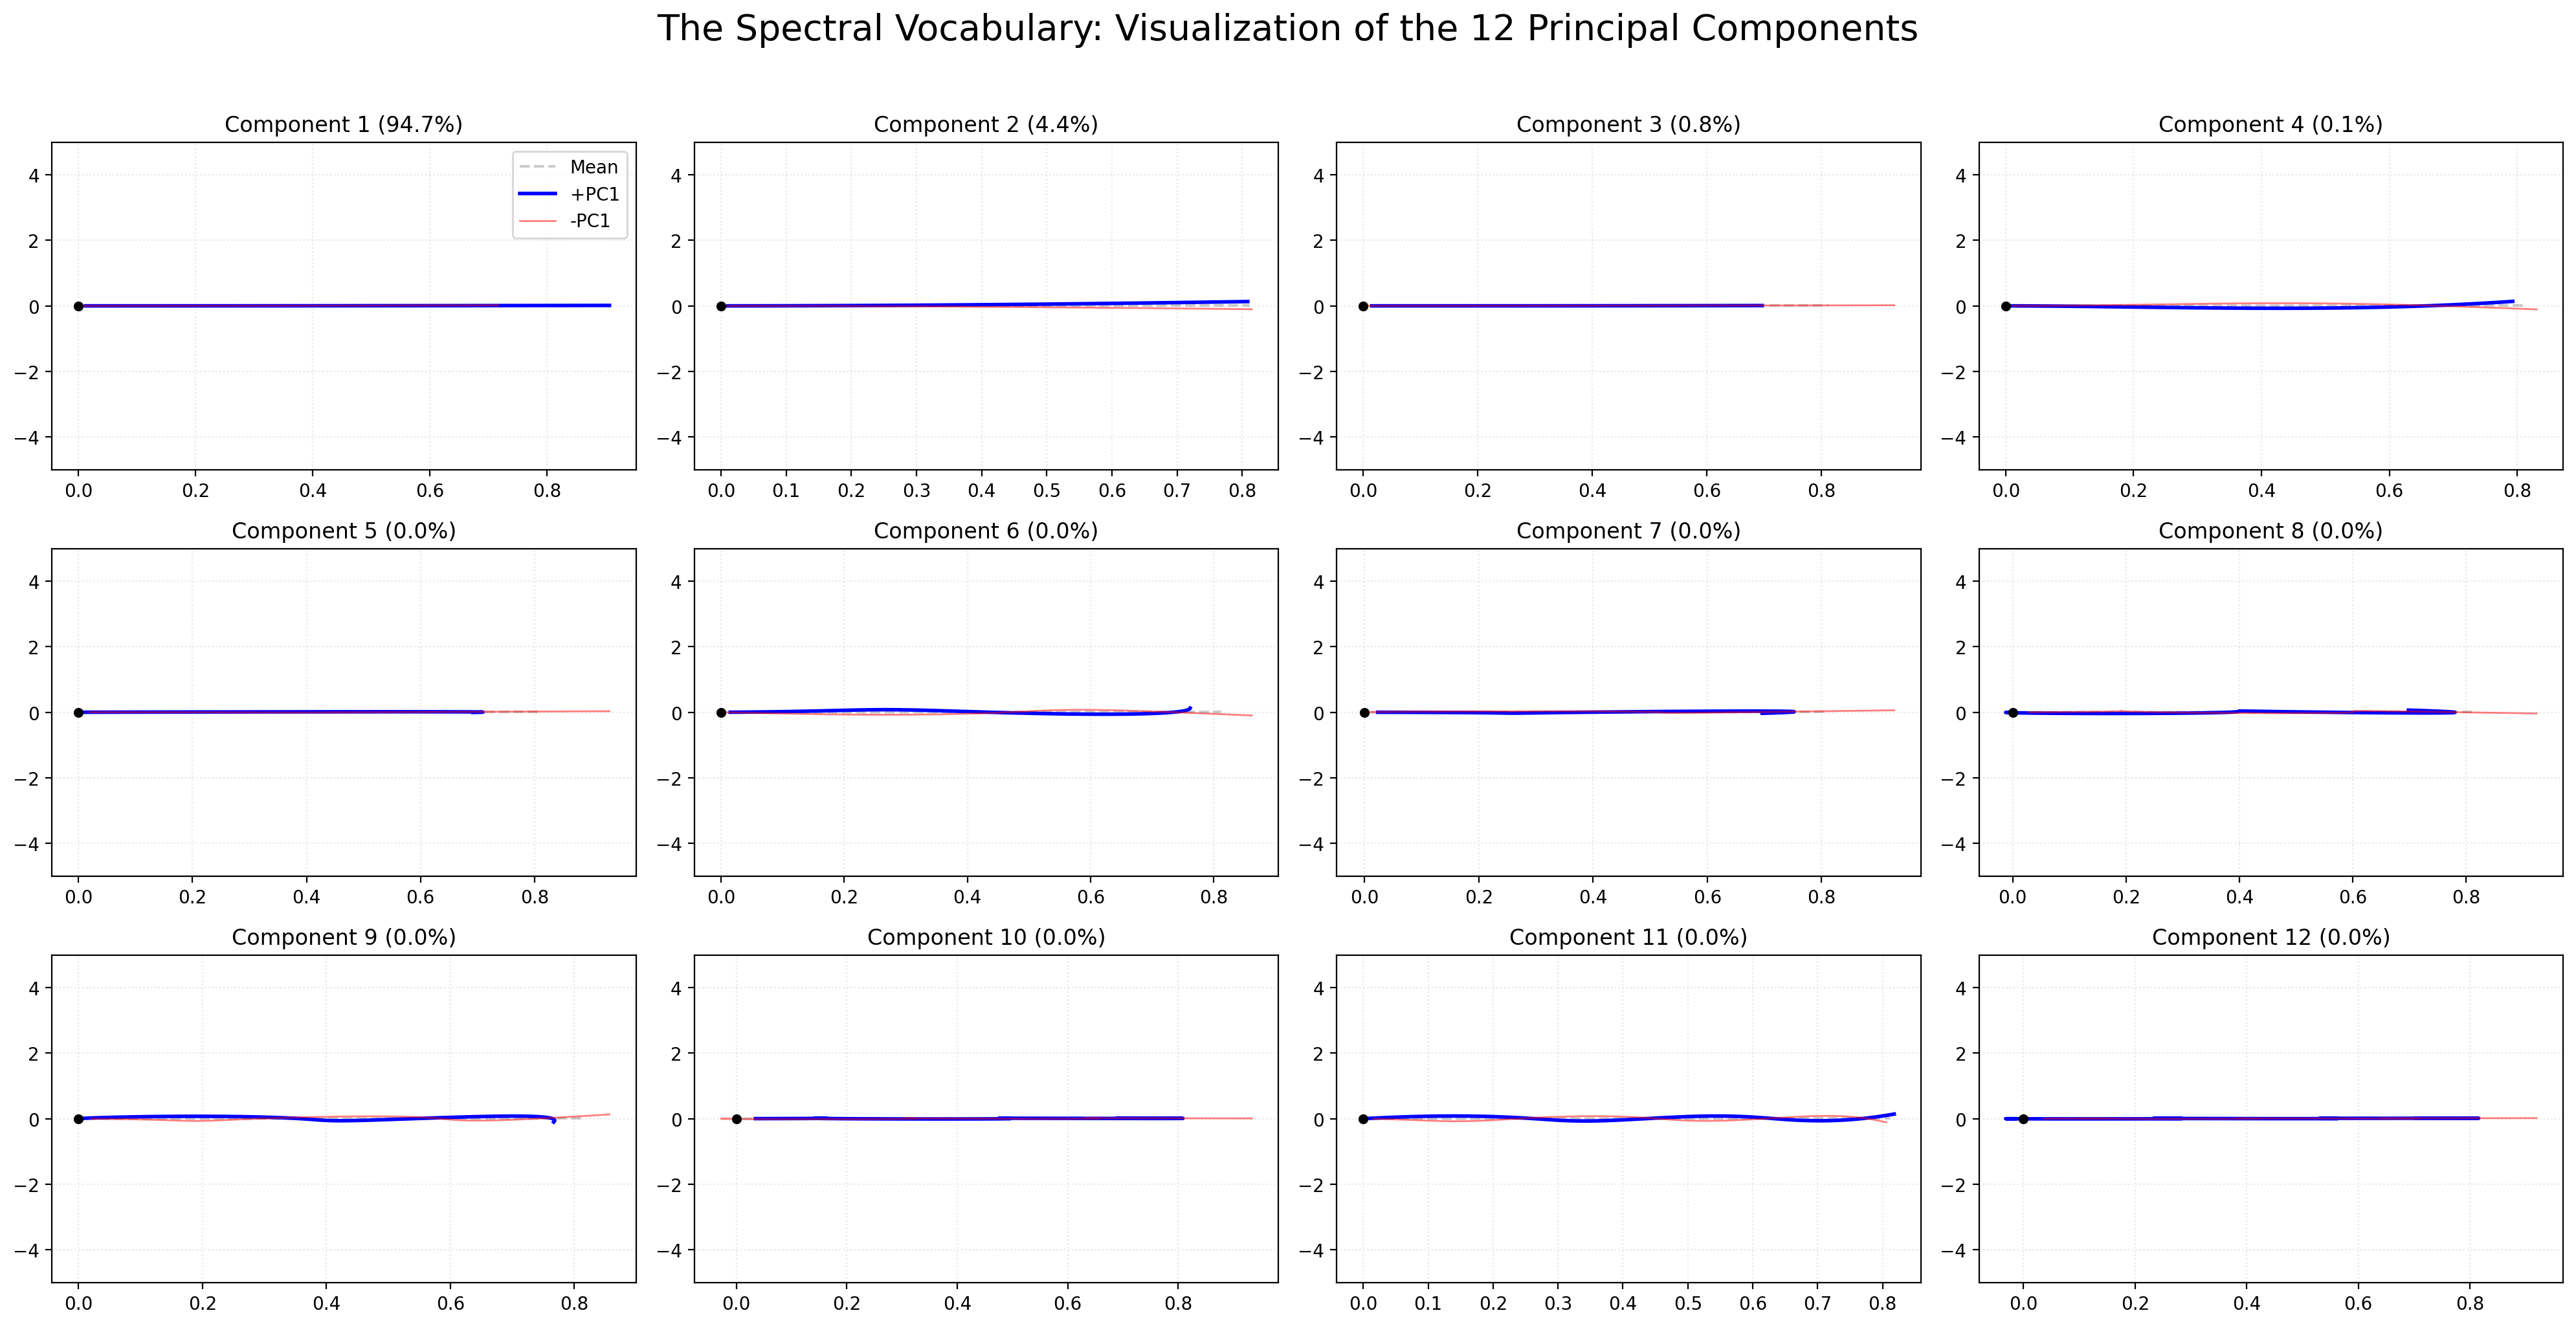

In [14]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
axes = axes.flatten()

# Reshape mean for plotting
m_traj = mean_traj.reshape(80, 2)

for i in range(12):
    ax = axes[i]
    
    # Extract the i-th component and reshape to coordinates
    pc = components[i].reshape(80, 2)
    
    # Calculate a "strong" version of this maneuver (+/- 3 standard deviations)
    # We use a multiplier of 0.2 here just for visual clarity of the shape
    plus_pc = m_traj + (pc * .5) 
    minus_pc = m_traj - (pc * .5)
    
    # Plot Mean (The baseline)
    ax.plot(m_traj[:, 0], m_traj[:, 1], color='grey', linestyle='--', alpha=0.4, label='Mean')
    
    # Plot the Component influence
    ax.plot(plus_pc[:, 0], plus_pc[:, 1], color='blue', lw=2, label=f'+PC{i+1}')
    ax.plot(minus_pc[:, 0], minus_pc[:, 1], color='red', lw=1, alpha=0.5, label=f'-PC{i+1}')
    
    # Mark Start
    ax.scatter(0, 0, color='black', s=20, zorder=5)
    
    ax.set_title(f"Component {i+1} ({variance_ratio[i]*100:.1f}%)")
    # ax.set_aspect('equal')
    
    ax.grid(True, linestyle=':', alpha=0.3)
    
    # limit y-axis to focus on the shape rather than scale
    ax.set_ylim(-5, 5)
    
    # Only show legend for the first one to save space
    if i == 0: ax.legend()

plt.suptitle("The Spectral Vocabulary: Visualization of the 12 Principal Components", fontsize=20, y=1.02)
plt.tight_layout()
# plt.savefig("../results/pca_analysis.pdf", dpi=300, bbox_inches='tight')
plt.show()

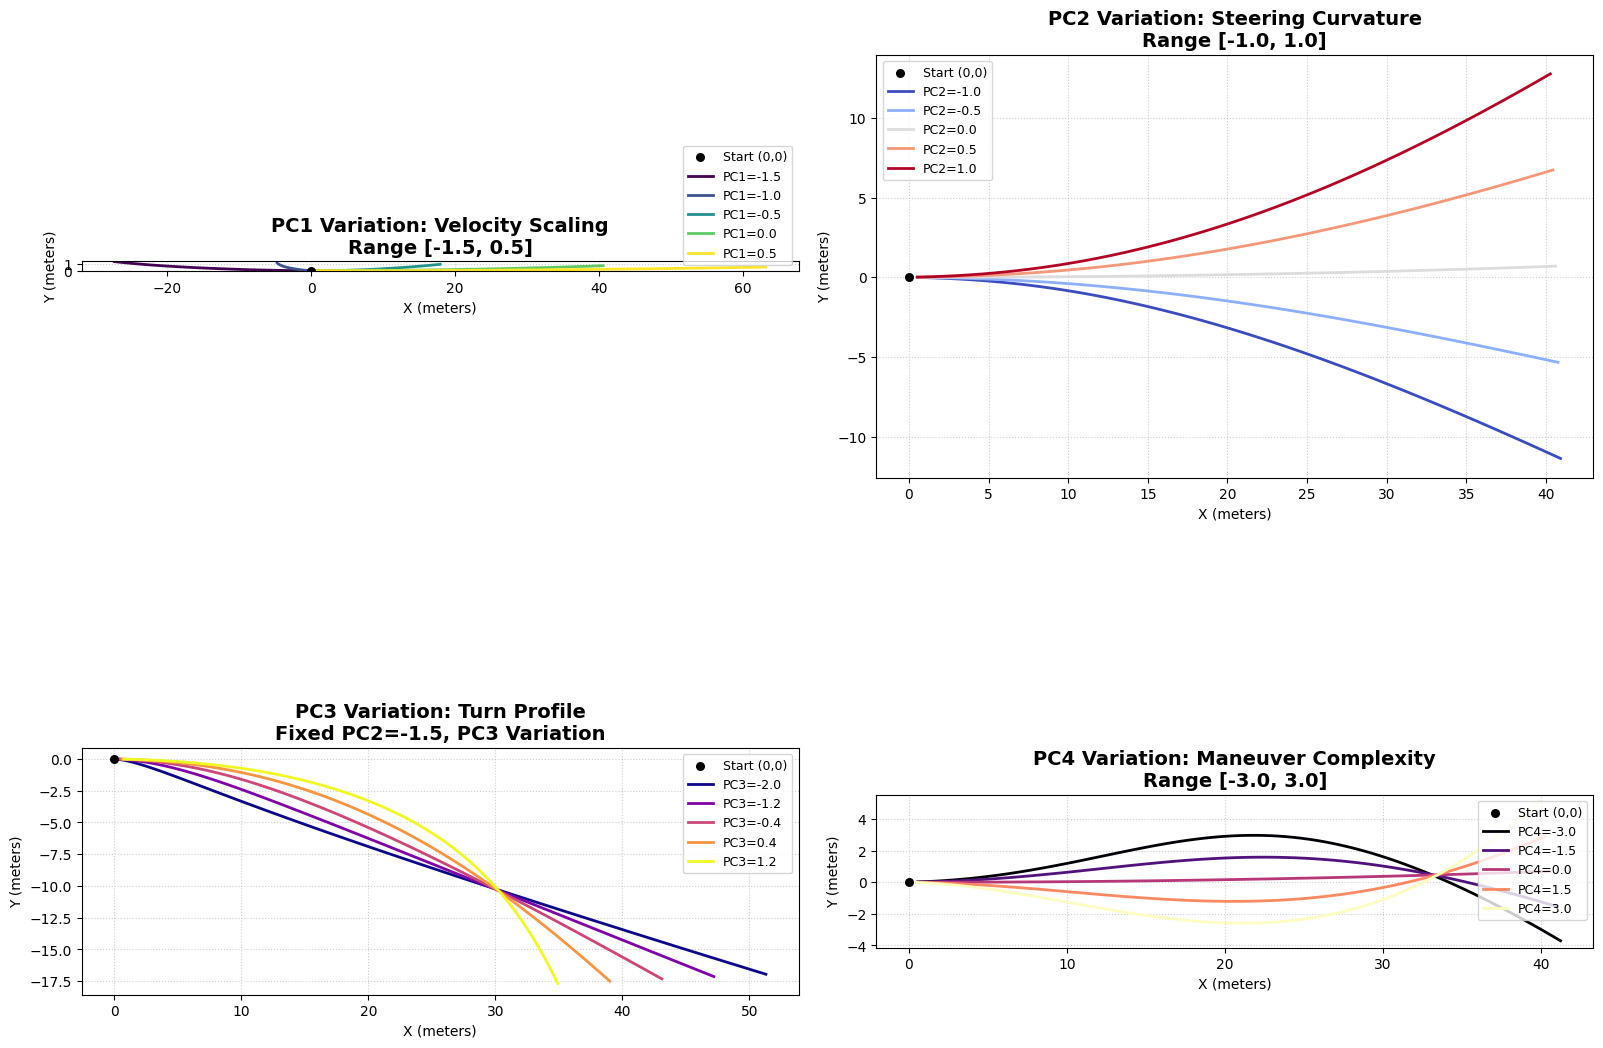

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# --- 1. Load PCA Data ---
pca_path = "/mnt/d/waymo_datasets/Deep-Flow_Dataset/pca_basis.json"
with open(pca_path, "r") as f:
    pca_data = json.load(f)

COMPONENTS = np.array(pca_data['components']) # [12, 160]
MEAN = np.array(pca_data['mean'])             # [160]
STDS = np.array(pca_data['stds'])             # [12]
SCALE_POS = 50.0

def reconstruct(coeffs_whitened):
    """
    Input: coeffs [12] (Whitened)
    Output: traj [80, 2] (Meters)
    """
    # 1. Un-whiten: coeffs * stds
    unwhitened = coeffs_whitened * STDS
    # 2. Project back: (coeffs @ components) + mean
    x_norm = (unwhitened @ COMPONENTS) + MEAN
    # 3. Scale to meters
    return x_norm.reshape(80, 2) * SCALE_POS

# --- 2. Setup Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

# Common settings
def format_ax(ax, title):
    ax.set_aspect('equal')
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.scatter(0, 0, color='black', s=30, label='Start (0,0)', zorder=5)
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")

# --- PANEL 1: PCA1 (Longitudinal Range) ---
ax = axes[0]
format_ax(ax, "PC1 Variation: Velocity Scaling\nRange [-1.5, 0.5]")
vals = np.linspace(-1.5, 0.5, 5)
colors = plt.cm.viridis(np.linspace(0, 1, len(vals)))
for v, col in zip(vals, colors):
    c = np.zeros(12); c[0] = v
    traj = reconstruct(c)
    ax.plot(traj[:,0], traj[:,1], color=col, lw=2, label=f"PC1={v:.1f}")

# --- PANEL 2: PCA2 (Curvature) ---
ax = axes[1]
format_ax(ax, "PC2 Variation: Steering Curvature\nRange [-1.0, 1.0]")
vals = np.linspace(-1.0, 1.0, 5)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(vals)))
for v, col in zip(vals, colors):
    c = np.zeros(12); c[1] = v
    traj = reconstruct(c)
    ax.plot(traj[:,0], traj[:,1], color=col, lw=2, label=f"PC2={v:.1f}")

# --- PANEL 3: PCA3 (Turn Modulation) ---
# Special Request: PC2 fixed at -1.5, vary PC3
ax = axes[2]
format_ax(ax, "PC3 Variation: Turn Profile\nFixed PC2=-1.5, PC3 Variation")
vals = np.linspace(-2.0, 1.2, 5) # Assuming 1.2 instead of 120
colors = plt.cm.plasma(np.linspace(0, 1, len(vals)))
for v, col in zip(vals, colors):
    c = np.zeros(12); c[1] = -1.5; c[2] = v
    traj = reconstruct(c)
    ax.plot(traj[:,0], traj[:,1], color=col, lw=2, label=f"PC3={v:.1f}")

# --- PANEL 4: PCA4 (Lateral S-Curves) ---
ax = axes[3]
format_ax(ax, "PC4 Variation: Maneuver Complexity\nRange [-3.0, 3.0]")
vals = np.linspace(-3.0, 3.0, 5)
colors = plt.cm.magma(np.linspace(0, 1, len(vals)))
for v, col in zip(vals, colors):
    c = np.zeros(12); c[3] = v
    traj = reconstruct(c)
    ax.plot(traj[:,0], traj[:,1], color=col, lw=2, label=f"PC4={v:.1f}")

for ax in axes: ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

Generating Spectral Manifold Visualizations...


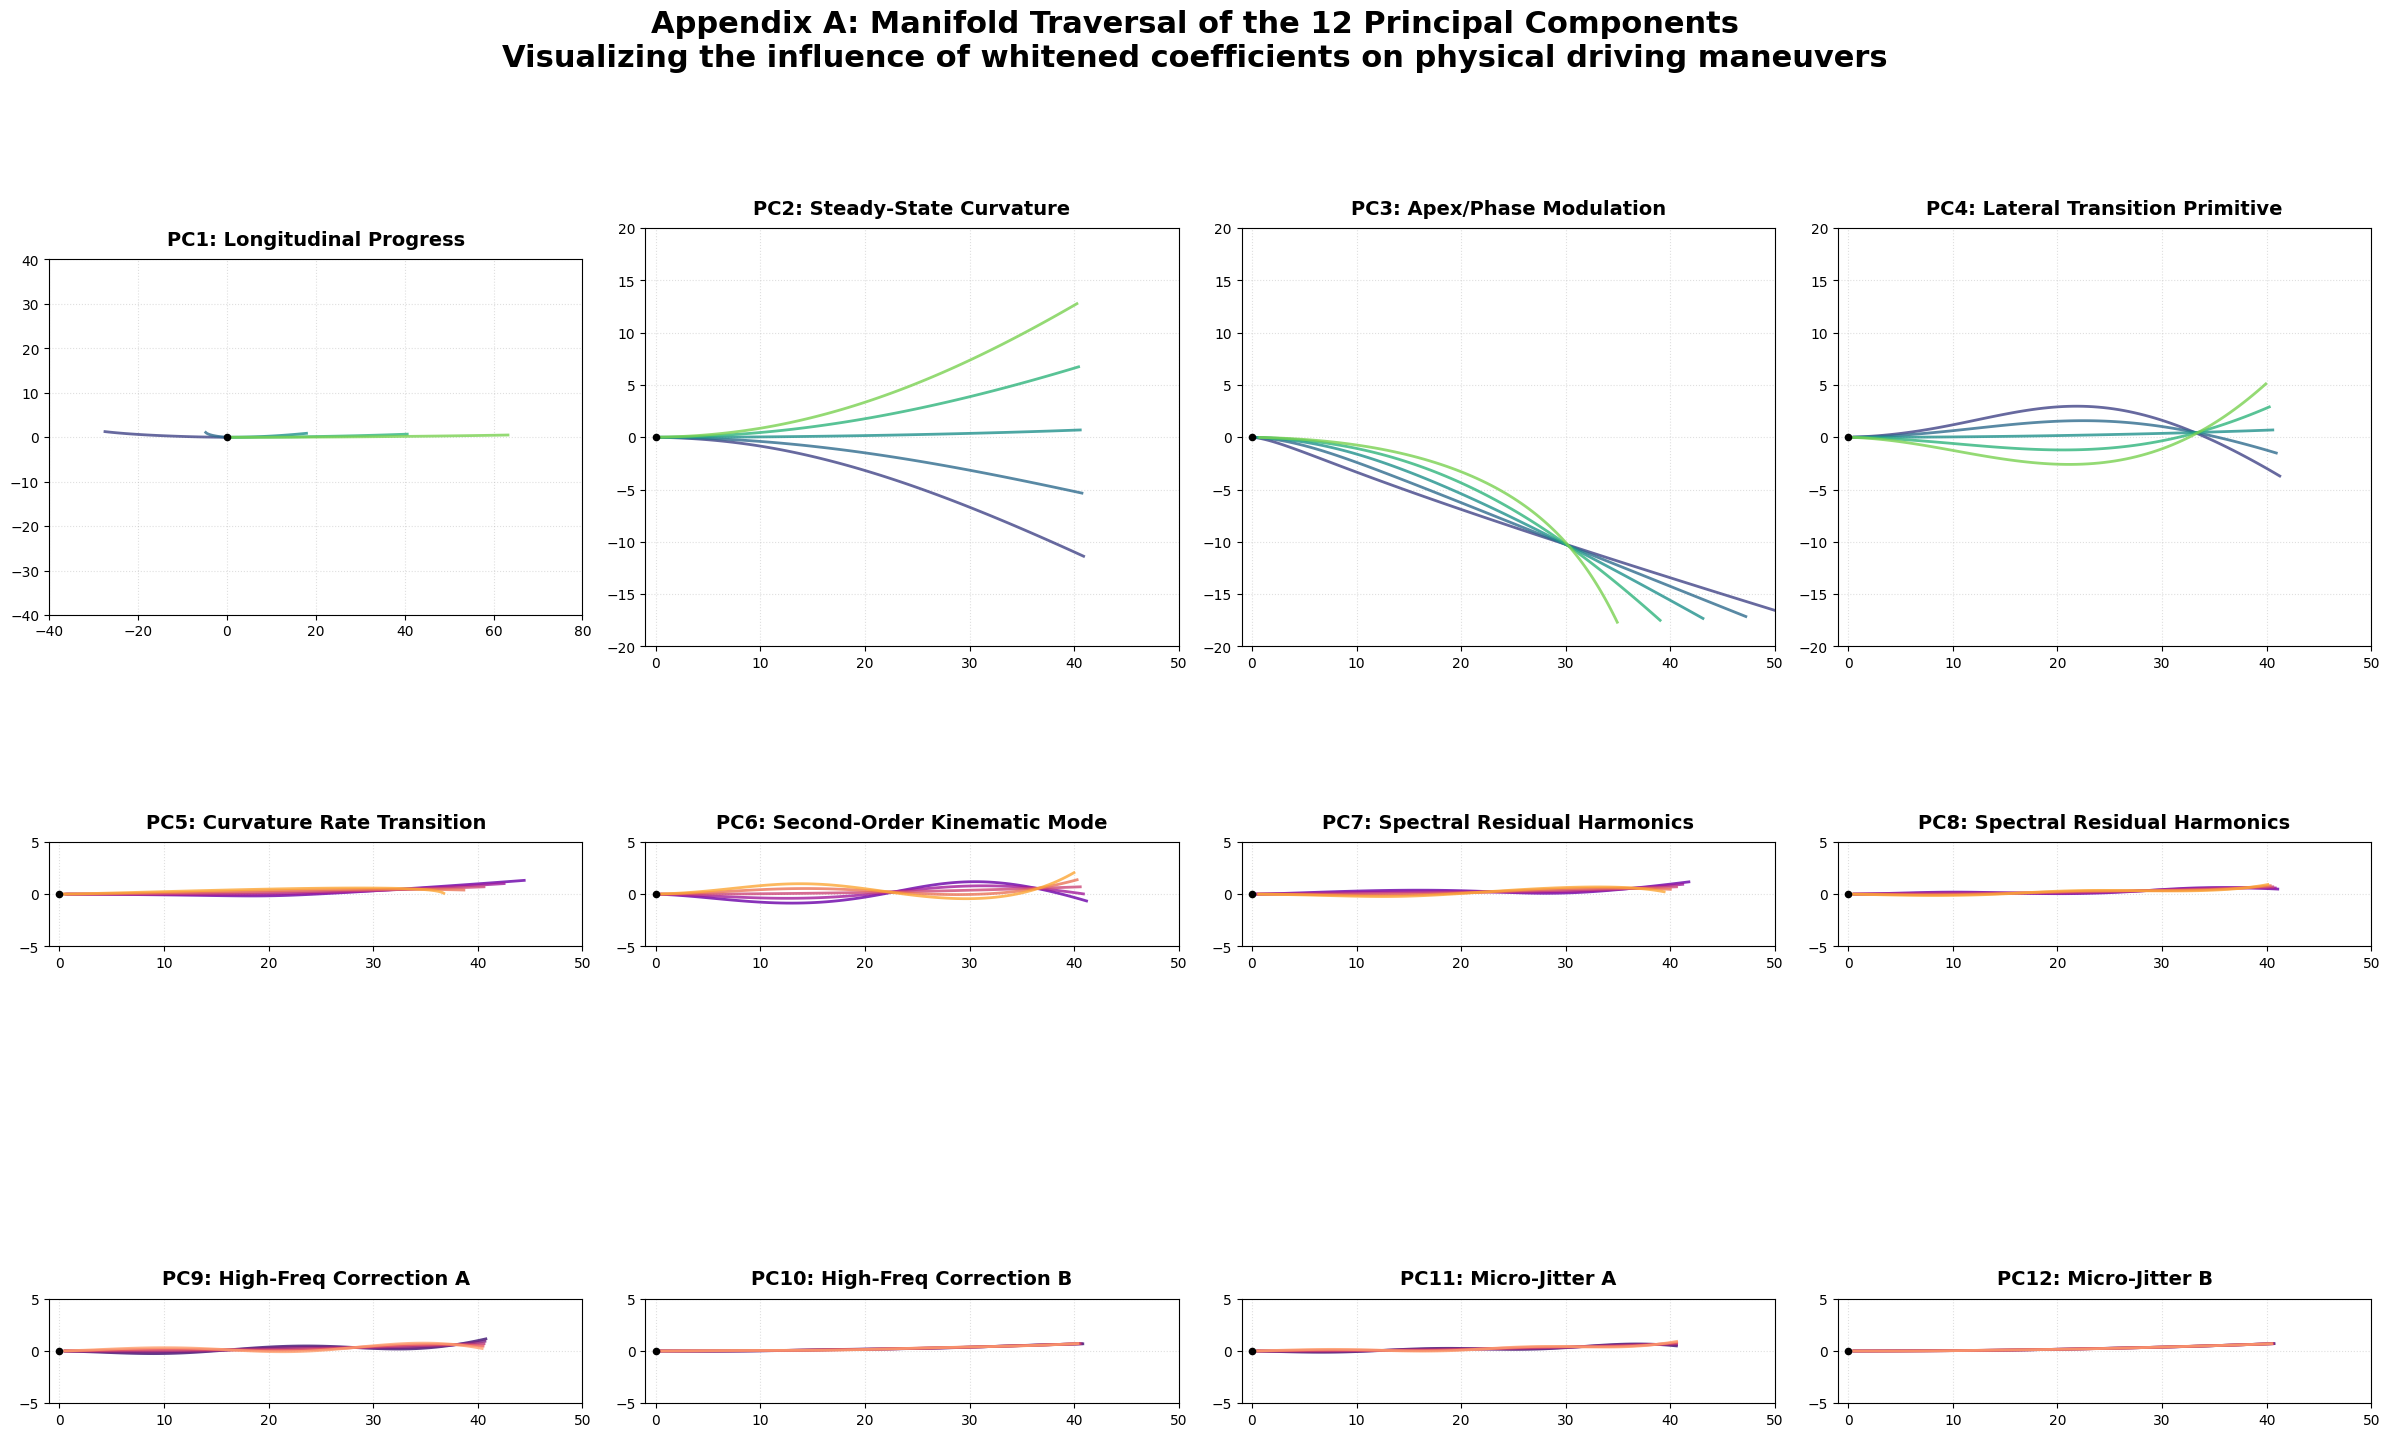

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# --- 1. Load PCA Data ---
pca_path = "/mnt/d/waymo_datasets/Deep-Flow_Dataset/pca_basis.json"
with open(pca_path, "r") as f:
    pca_data = json.load(f)

COMPONENTS = np.array(pca_data['components']) # [12, 160]
MEAN = np.array(pca_data['mean'])             # [160]
STDS = np.array(pca_data['stds'])             # [12]
SCALE_POS = 50.0

def reconstruct(coeffs_whitened):
    """
    Input: coeffs [12] (Whitened/Standardized)
    Output: traj [80, 2] (Meters)
    """
    # 1. Un-whiten: coeffs * stds
    unwhitened = coeffs_whitened * STDS
    # 2. Project back: (coeffs @ components) + mean
    x_norm = (unwhitened @ COMPONENTS) + MEAN
    # 3. Scale back to meters
    return x_norm.reshape(80, 2) * SCALE_POS

# --- 2. Setup 3x4 Grid Plotting ---
fig, axes = plt.subplots(3, 4, figsize=(24, 18))
axes = axes.flatten()

# Semantic Variation Map
variations = {
    0: {"range": (-1.5, 0.5), "label": "PC1: Longitudinal Progress", "fixed": {}},
    1: {"range": (-1.0, 1.0), "label": "PC2: Steady-State Curvature", "fixed": {}},
    2: {"range": (-2.0, 1.2), "label": "PC3: Apex/Phase Modulation", "fixed": {1: -1.5}},
    3: {"range": (-3.0, 3.0), "label": "PC4: Lateral Transition Primitive", "fixed": {}},
    # Extrapolating for 5-12 with wider ranges to see the 'high-frequency' impact
    4: {"range": (-4.0, 4.0), "label": "PC5: Curvature Rate Transition", "fixed": {}},
    5: {"range": (-4.0, 4.0), "label": "PC6: Second-Order Kinematic Mode", "fixed": {}},
    6: {"range": (-4.0, 4.0), "label": "PC7: Spectral Residual Harmonics", "fixed": {}},
    7: {"range": (-4.0, 4.0), "label": "PC8: Spectral Residual Harmonics", "fixed": {}},
    8: {"range": (-4.0, 4.0), "label": "PC9: High-Freq Correction A", "fixed": {}},
    9: {"range": (-4.0, 4.0), "label": "PC10: High-Freq Correction B", "fixed": {}},
    10: {"range": (-4.0, 4.0), "label": "PC11: Micro-Jitter A", "fixed": {}},
    11: {"range": (-4.0, 4.0), "label": "PC12: Micro-Jitter B", "fixed": {}},
}

print("Generating Spectral Manifold Visualizations...")

for i in range(12):
    ax = axes[i]
    config = variations[i]
    
    # Setup axis
    ax.set_aspect('equal')
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.set_title(config['label'], fontsize=14, fontweight='bold', pad=10)
    ax.scatter(0, 0, color='black', s=20, zorder=5) # Ego Position
    
    # Generate 5 levels of variation
    v_min, v_max = config['range']
    vals = np.linspace(v_min, v_max, 5)
    
    # Choose a distinct color map for each row to keep visual interest
    cmap_name = 'viridis' if i < 4 else ('plasma' if i < 8 else 'magma')
    colors = plt.get_cmap(cmap_name)(np.linspace(0.2, 0.8, len(vals)))
    
    for v, col in zip(vals, colors):
        # Initialize all coefficients to 0
        c = np.zeros(12)
        
        # Apply fixed offsets (e.g., PC2 = -1.5 for the PC3 plot)
        for f_idx, f_val in config['fixed'].items():
            c[f_idx] = f_val
            
        # Apply current variation
        c[i] = v
        
        # Reconstruct and plot
        traj = reconstruct(c)
        ax.plot(traj[:, 0], traj[:, 1], color=col, lw=2, alpha=0.8, label=f"v={v:.1f}")

    # Set consistent limits to see relative scale
    # PC1-4 usually need wider views, PC9-12 are much smaller
    if i == 0:
        ax.set_xlim(-40, 80)
        ax.set_ylim(-40, 40)
        
    elif i < 4:
        ax.set_xlim(-1, 50)
        ax.set_ylim(-20, 20)
    else:
        # Zoom in for high-frequency components
        ax.set_xlim(-1, 50)
        ax.set_ylim(-5, 5)

# Final Polish
plt.suptitle("Appendix A: Manifold Traversal of the 12 Principal Components\n"
             "Visualizing the influence of whitened coefficients on physical driving maneuvers", 
             fontsize=22, y=0.95, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.93])

# Save the figure
plt.savefig("../results/pca_manifold_traversal.pdf", dpi=300, bbox_inches='tight')

plt.show()